Here, we create a multiclass classifier for classifying the various closest vectors returned by the model, as the corresponding attributes.

In [171]:
import warnings
warnings.filterwarnings('ignore')

from gensim.models.wrappers import FastText
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import pandas as pd
import numpy as np
import h5py
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing import sequence
from keras import models
from keras import layers
from keras import activations
from keras import optimizers
from keras import losses
from keras import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras.preprocessing.text
from keras.models import load_model
from keras.utils import np_utils

import matplotlib.pyplot as plt
%matplotlib inline

## Prepare Dataset

In [172]:
#df = pd.read_csv('truthvalue.csv', encoding='utf8', dtype=object)

In [173]:
df = pd.read_csv('CensusTrainingDataMultiAttributes.csv', encoding='utf8', dtype=object)

In [174]:
df.shape

(93590, 41)

In [175]:
#df = df.drop(columns=['City', 'State'])
#df = df.drop(columns=['label'])
df.replace(np.nan,'empty',inplace = True)
#df.rename(columns={'City.1': 'City'}, inplace=True)
#df.replace(np.nan,'empty',inplace = True)

In [176]:
df.columns.values

array(['age', 'class_of_worker', 'detailed_industry_recode',
       'detailed_occupation_recode', 'education', 'wage_per_hour',
       'enroll_in_edu_inst_last_wk', 'marital_stat',
       'major_industry_code', 'major_occupation_code', 'race',
       'hispanic_origin', 'sex', 'member_of_a_labor_union',
       'reason_for_unemployment', 'full_or_part_time_employment_stat',
       'capital_gains', 'capital_losses', 'dividends_from_stocks',
       'tax_filer_stat', 'region_of_previous_residence',
       'state_of_previous_residence',
       'detailed_household_and_family_stat',
       'detailed_household_summary_in_household', 'instance_weight',
       'migration_code-change_in_msa', 'migration_code-change_in_reg',
       'migration_code-move_within_reg', 'live_in_this_house_1_year_ago',
       'migration_prev_res_in_sunbelt', 'num_persons_worked_for_employer',
       'family_members_under_18', 'country_of_birth_father',
       'country_of_birth_mother', 'country_of_birth_self', 'citizens

## Data Cleaning

In [177]:
#df['ProviderNumber'] = df['ProviderNumber'].apply(lambda x: str(int(float(x))))
#df['ZipCode'] = df['ZipCode'].apply(lambda x: str(int(float(x))))
#df['PhoneNumber'] = df['PhoneNumber'].apply(lambda x: str(int(float(x))))

In [178]:
df.head(2)

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,veterans_benefits,weeks_worked_in_year,year,income
0,53,local government,47,28,some college but no degree,2100,not in universe,married-civilian spouse present,public administration,protective services,...,not in universe,united-states,united-states,united-states,native- born in the united states,0,2,52,94,50000+.
1,68,not in universe,0,0,7th and 8th grade,0,not in universe,married-civilian spouse present,not in universe or children,not in universe,...,not in universe,united-states,united-states,united-states,native- born in the united states,0,2,0,94,- 50000.


In [179]:
df.shape

(93590, 41)

In [180]:
values = []
for i in df.columns:
    values.append(df[i].tolist())

In [181]:
attributes = df.columns.tolist()

Create value, attribute-name tuple pairs

In [182]:
data = []
for i in range(len(values)):
    for value in values[i]:
        data.append([value.lower(), attributes[i]])

In [183]:
len(data)

3837190

In [184]:
data[:10]

[['53', 'age'],
 ['68', 'age'],
 ['x5', 'age'],
 ['5', 'age'],
 ['42', 'age'],
 ['37', 'age'],
 ['27', 'age'],
 ['60', 'age'],
 ['0', 'age'],
 ['34', 'age']]

In [185]:
data[-10:]

[[' - 50000.', 'income'],
 [' - 50000.', 'income'],
 [' - 50000.', 'income'],
 [' - 50000.', 'income'],
 [' - 50000.', 'income'],
 [' - 50000.', 'income'],
 [' - 50000.', 'income'],
 [' - 50000.', 'income'],
 [' 50000+.', 'income'],
 [' - 50000.', 'income']]

In [186]:
dfData = pd.DataFrame(data, columns=['Value','Label'])

In [187]:
dfData.head(2)

,Value,Label
0,53,age
1,68,age


In [188]:
dfData.tail()

,Value,Label
3837185,- 50000.,income
3837186,- 50000.,income
3837187,- 50000.,income
3837188,50000+.,income
3837189,- 50000.,income


Convert labels to categorical attributes

In [189]:
dfData['Label'] = dfData['Label'].astype('category')

In [190]:
dfData["Label_Cat"] = dfData["Label"].cat.codes

In [191]:
dfData.tail()

,Value,Label,Label_Cat
3837185,- 50000.,income,18
3837186,- 50000.,income,18
3837187,- 50000.,income,18
3837188,50000+.,income,18
3837189,- 50000.,income,18


In [192]:
dfData['Label_Cat'].value_counts()

40    93590
19    93590
17    93590
16    93590
15    93590
14    93590
13    93590
12    93590
11    93590
10    93590
9     93590
8     93590
7     93590
6     93590
5     93590
4     93590
3     93590
2     93590
1     93590
18    93590
20    93590
39    93590
21    93590
38    93590
37    93590
36    93590
35    93590
34    93590
33    93590
32    93590
31    93590
30    93590
29    93590
28    93590
27    93590
26    93590
25    93590
24    93590
23    93590
22    93590
0     93590
Name: Label_Cat, dtype: int64

Get the mapping

In [193]:
mapping = dict(enumerate(dfData['Label'].cat.categories))

In [194]:
mapping

{0: 'age',
 1: 'capital_gains',
 2: 'capital_losses',
 3: 'citizenship',
 4: 'class_of_worker',
 5: 'country_of_birth_father',
 6: 'country_of_birth_mother',
 7: 'country_of_birth_self',
 8: 'detailed_household_and_family_stat',
 9: 'detailed_household_summary_in_household',
 10: 'detailed_industry_recode',
 11: 'detailed_occupation_recode',
 12: 'dividends_from_stocks',
 13: 'education',
 14: 'enroll_in_edu_inst_last_wk',
 15: 'family_members_under_18',
 16: 'full_or_part_time_employment_stat',
 17: 'hispanic_origin',
 18: 'income',
 19: 'instance_weight',
 20: 'live_in_this_house_1_year_ago',
 21: 'major_industry_code',
 22: 'major_occupation_code',
 23: 'marital_stat',
 24: 'member_of_a_labor_union',
 25: 'migration_code-change_in_msa',
 26: 'migration_code-change_in_reg',
 27: 'migration_code-move_within_reg',
 28: 'migration_prev_res_in_sunbelt',
 29: 'num_persons_worked_for_employer',
 30: 'own_business_or_self_employed',
 31: 'race',
 32: 'reason_for_unemployment',
 33: 'region_

Drop the Label column

In [195]:
dfData.drop(['Label'], axis=1, inplace=True)

In [196]:
dfData.head()

,Value,Label_Cat
0,53,0
1,68,0
2,x5,0
3,5,0
4,42,0


Shuffle the data

In [197]:
dfData = dfData.sample(frac=1).reset_index(drop=True)

In [198]:
dfData.head(10)

,Value,Label_Cat
0,not in universe,22
1,nonmover,27
2,94,40
3,0,1
4,nonfamily householder,8
5,private,4
6,white,31
7,0,2
8,self-employed-incorporated,4
9,united-states,6


Find the longest string in the value column

In [199]:
maxLength = dfData.Value.map(lambda x: len(str(x))).max()

In [200]:
X = dfData['Value'].tolist()
y = dfData['Label_Cat'].tolist()

## Tokenize and obtain the train, test split

In [201]:
batchSize = 32
maxSequenceLength = maxLength
maxWords = 2 * sum(dfData.nunique())

In [202]:
tokenizer = Tokenizer(num_words=maxWords)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 7570 unique tokens.


In [203]:
data = pad_sequences(sequences, maxlen=maxSequenceLength)

In [204]:
labels = np.asarray(y)

In [205]:
data.shape

(3837190, 48)

In [206]:
labels.shape

(3837190,)

In [207]:
labels = to_categorical(labels)

In [208]:
labels.shape

(3837190, 41)

Shuffle the dataset

In [209]:
indices = np.arange(data.shape[0])
#np.random.shuffle(indices)

In [210]:
data = data[indices]
labels = labels[indices]

## Train test split

In [211]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=22, stratify=labels)

In [212]:
len(X_train), len(y_train)

(3069752, 3069752)

In [213]:
len(X_test), len(y_test)

(767438, 767438)

## Model

In [214]:
embeddingDim = 100

**Architecture**
* 1 embedding layer 
* 1 dense layer, 32 hidden units and _relu_ activation
* 1 dense layer, 64 hidden units and _relu_ activation
* Output layer, _softmax_ activation

In [215]:
model = models.Sequential()
model.add(layers.Embedding(maxWords, embeddingDim, input_length=maxSequenceLength))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation=activations.relu))
model.add(layers.Dense(64, activation=activations.relu))
model.add(layers.Dense(labels.shape[1], activation=activations.softmax))

model.compile(optimizer=optimizers.Adam(), loss=losses.categorical_crossentropy, metrics=['accuracy'])

In [216]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 48, 100)           11384200  
_________________________________________________________________
flatten_4 (Flatten)          (None, 4800)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                153632    
_________________________________________________________________
dense_11 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_12 (Dense)             (None, 41)                2665      
Total params: 11,542,609
Trainable params: 11,542,609
Non-trainable params: 0
_________________________________________________________________


In [217]:
history = model.fit(X_train, y_train,
                    epochs=3,
                    batch_size=32, 
                    validation_split=0.5)

Train on 1534876 samples, validate on 1534876 samples
Epoch 1/3
1534876/1534876 [==============================] - 5804s 4ms/step - loss: 1.0779 - acc: 0.5542 - val_loss: 1.0459 - val_acc: 0.5601
Epoch 2/3
1534876/1534876 [==============================] - 5588s 4ms/step - loss: 1.0454 - acc: 0.5605 - val_loss: 1.0474 - val_acc: 0.5586
Epoch 3/3
1534876/1534876 [==============================] - 4780s 3ms/step - loss: 1.0440 - acc: 0.5618 - val_loss: 1.0486 - val_acc: 0.5576


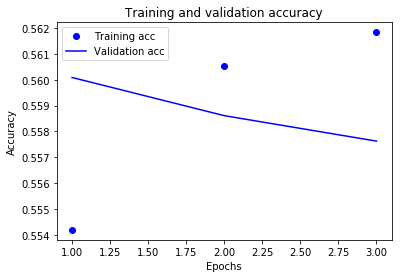

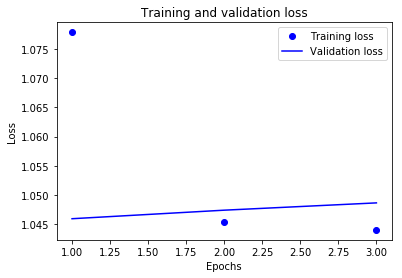

In [218]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

In [219]:
results = model.evaluate(X_test, y_test)

767438/767438 [==============================] - 25s 32us/step


In [220]:
loss = results[0]
accuracy = results[1]

In [221]:
loss

1.049217917039011

In [222]:
accuracy

0.5573127731495673

Save the model

In [223]:
model.save("CensusMultiAttributeClassifier.h5")

Save the tokenizer

In [224]:
with open('CensusMultiAttributeClassifierTokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL, fix_imports=True)

## Make predictions on new data

In [225]:
model = load_model('CensusMultiAttributeClassifier.h5')

In [226]:
with open('CensusMultiAttributeClassifierTokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [227]:
testString = ['united states']

In [228]:
sequences = tokenizer.texts_to_sequences(testString)
testData = pad_sequences(sequences, maxlen=maxLength)

In [229]:
predictions = model.predict(testData)

In [230]:
#mapping = dict(enumerate(df.columns.astype('category').categories))

In [231]:
mapping[np.argmax(predictions[0])]

'country_of_birth_self'